<a href="https://colab.research.google.com/github/ryanbrito/FACE_RECOGNITION_PBL_FIAP/blob/main/FACE_RECOGNITION_PBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Recognition PBL**

## Libs Installation

In [69]:
!pip install -q deepface opencv-python-headless matplotlib tqdm pandas

## Imports

In [70]:
from deepface import DeepFace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os, shutil
from tqdm import tqdm

# Exploring: THE FACES BEHIND THE MOST INFLUENTIAL TECH MINDS OF RECENT DECADES

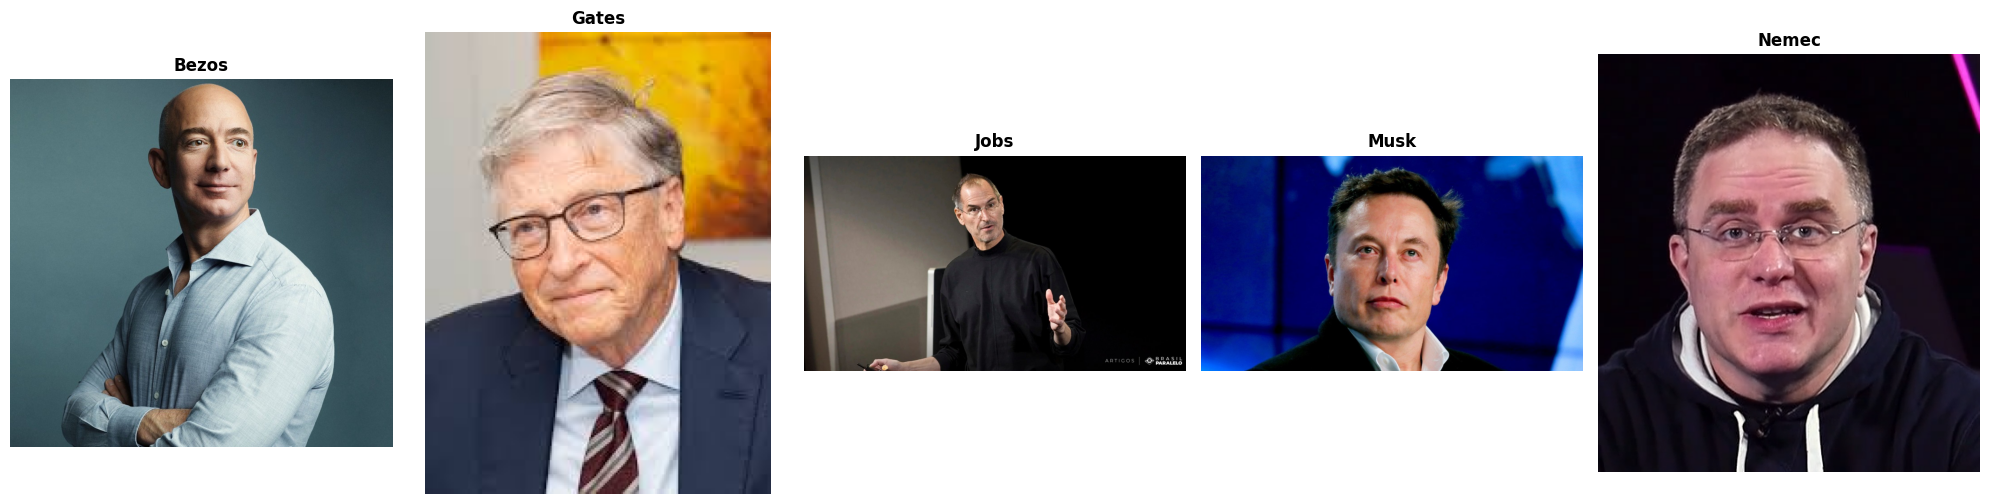

In [71]:
base_dir = "/content/FACES"

# Lista ordenada de pessoas (pastas)
pessoas = sorted([p for p in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, p))])

# Define tamanho da figura — aumenta conforme o número de pessoas
fig, axes = plt.subplots(1, len(pessoas), figsize=(4*len(pessoas), 5))

if len(pessoas) == 1:
    axes = [axes]  # garante que axes seja sempre iterável

for ax, person in zip(axes, pessoas):
    person_dir = os.path.join(base_dir, person)
    imagens = sorted(os.listdir(person_dir))

    # Pega a primeira imagem
    primeira_imagem = os.path.join(person_dir, imagens[0])
    img = Image.open(primeira_imagem)

    # Exibe no subplot
    ax.imshow(img)
    ax.set_title(person, fontsize=12, fontweight='bold')
    ax.axis("off")

plt.tight_layout()
plt.show()

## Variables Definition

In [72]:
base_dir = "/content/FACES"

embeddings = []   # vetores de características (modelo)
labels = []       # nomes (rótulos)
test_images = []  # 5ª imagem de cada pessoa para teste

## Train & Test Split
*Generates the embeddings for train images and saves the path and name of the person for the test images in a list*

In [73]:
print("\nGerando embeddings das 4 primeiras imagens de cada pessoa...\n")

for person in tqdm(os.listdir(base_dir)):
    person_dir = os.path.join(base_dir, person)
    if not os.path.isdir(person_dir):
        continue

    images = sorted(os.listdir(person_dir))
    if len(images) < 5:
        print(f"Aviso: {person} tem menos de 5 imagens, será ignorado.")
        continue

    # 4 primeiras imagens = treino
    for img_name in images[:4]:
        img_path = os.path.join(person_dir, img_name)
        rep = DeepFace.represent(img_path=img_path, model_name='VGG-Face', enforce_detection=False)
        rep_arr = np.array(rep[0]["embedding"]).flatten()
        embeddings.append(rep_arr)
        labels.append(person)

    # 5ª imagem = teste
    test_images.append((person, os.path.join(person_dir, images[4])))

embeddings = np.vstack(embeddings)
labels = np.array(labels)

print(f"\nModelo criado com {len(labels)} imagens de treino ({len(np.unique(labels))} pessoas).")
print(f"Cada embedding possui {embeddings.shape[1]} dimensões.")

print(f"{len(test_images)} imagens para teste")


Gerando embeddings das 4 primeiras imagens de cada pessoa...



100%|██████████| 5/5 [00:48<00:00,  9.72s/it]


Modelo criado com 20 imagens de treino (5 pessoas).
Cada embedding possui 4096 dimensões.
5 imagens para teste


## Face Name Predictor Function

In [74]:
def predict_name(test_embedding, embeddings_db, labels_db):
    dists = np.linalg.norm(embeddings_db - test_embedding, axis=1)
    best_idx = np.argmin(dists)
    return labels_db[best_idx], dists[best_idx]

## Test with 5th Image


Iniciando testes...



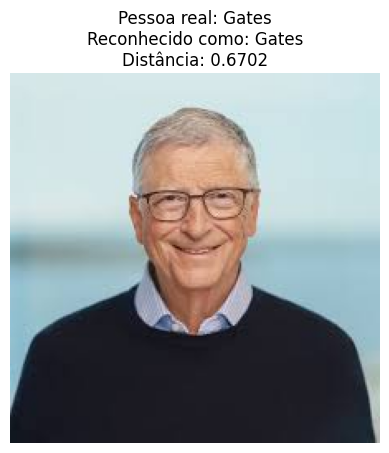

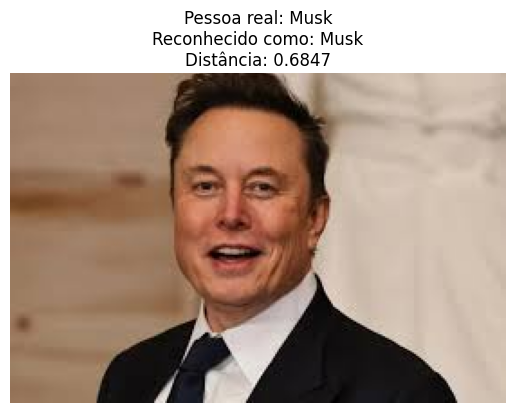

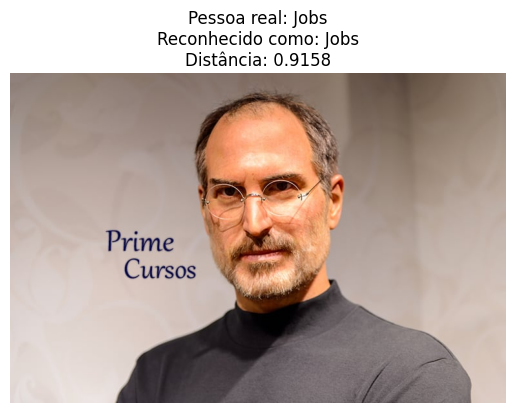

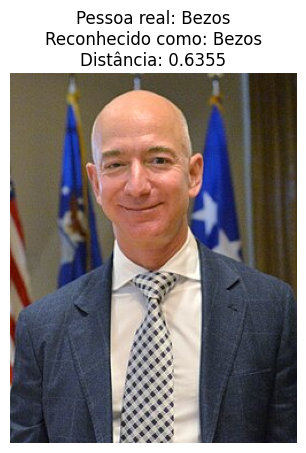

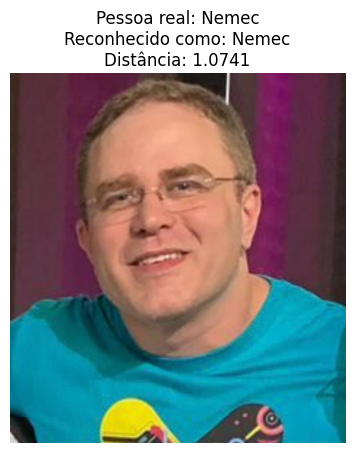

In [75]:
print("\nIniciando testes...\n")
results = []

for person, test_path in test_images:
    rep_test = DeepFace.represent(img_path=test_path, model_name='VGG-Face', enforce_detection=False)
    test_embedding = np.array(rep_test[0]["embedding"]).flatten()

    pred_name, dist = predict_name(test_embedding, embeddings, labels)
    results.append((person, pred_name, dist))

    # Mostrar imagem
    img = Image.open(test_path)
    plt.imshow(img)
    plt.title(f"Pessoa real: {person}\nReconhecido como: {pred_name}\nDistância: {dist:.4f}")
    plt.axis("off")
    plt.show()

## Final Results Evaluation

In [76]:
df_results = pd.DataFrame(results, columns=["Real", "Predito", "Distância"])
df_results["Correto"] = df_results["Real"] == df_results["Predito"]

print("\nResumo dos testes:")
print(df_results)
print("\nAcurácia total:", round(df_results["Correto"].mean() * 100, 2), "%")


Resumo dos testes:
    Real Predito  Distância  Correto
0  Gates   Gates   0.670231     True
1   Musk    Musk   0.684722     True
2   Jobs    Jobs   0.915826     True
3  Bezos   Bezos   0.635516     True
4  Nemec   Nemec   1.074104     True

Acurácia total: 100.0 %
